# `timex_lca` example: time-explicit LCA of an electric vehicle


This notebook shows how to use `timex_lca` with a cradle-to-grave case study of an electric vehicle. The case study is simplified, not meant to reflect the complexity of electric mobility but to demonstrate hot to use `timex_lca`.

More information on the inner workings of `timex_lca` can be found [here](https://timex.readthedocs.io/en/latest/content/theory.html).

In [1]:
import bw2data as bd

bd.projects.set_current("bw25_premise")

## Prospective databases

Created using [Ecoinvent v3.9](https://ecoinvent.org/)  and [`premise`](https://github.com/polca/premise), with projections for the future electricity sectors using the SSP2-RCP19 pathway from the IAM IMAGE.


In [2]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

## Case study setup


Let's make sure we start from scratch:


In [3]:
del bd.databases["foreground"]
foreground = bd.Database("foreground")
foreground.write({})

Getting the input processes of the EV from the background database:


In [4]:
glider_production = bd.get_activity(("db_2020", "133b33cc867081af144475d62179286b"))
powertrain_production = bd.get_activity(
    ("db_2020", "f6d3f0b01e4a38c055e3c5c1356a4bba")
)  # eol included
battery_production = bd.get_activity(("db_2020", "ba87aff6361d99be2636e8c59e55a5b2"))
electricity_production = bd.get_activity(
    ("db_2020", "fec93a95a9a84d7fa0ede9c3082bb79f")
)
glider_eol = bd.get_activity(("db_2020", "f8114e0ff375b3c6d72ccfa49f79e44d"))
battery_eol = bd.get_activity(("db_2020", "82ebcdf42e8512cbe00151dda6210d29"))

Creating the EV activity:


In [5]:
fg = bd.Database("foreground")

In [6]:
fg.new_node("EV_lifecycle", name="Electric vehicle, lifecycle", unit="unit").save()
ev_lifecycle = fg.get("EV_lifecycle")

Here are some parameter assumptions for the EV:


In [7]:
ELECTRICITY_CONSUMPTION = 0.2  # kWh/km
MILEAGE = 150_000  # km
LIFETIME = 15  # years

# Overall mass: 1200 kg
MASS_GLIDER = 840  # kg
MASS_POWERTRAIN = 80  # kg
MASS_BATTERY = 280  # kg

Based on these parameters, we create the following exchanges:


In [8]:
ev_lifecycle.new_edge(input=ev_lifecycle, amount=1, type="production").save() # production exchange

In [9]:
glider_production_exchange = ev_lifecycle.new_edge(
    input=glider_production, 
    amount=MASS_GLIDER, 
    type="technosphere"
)

powertrain_production_exchange = ev_lifecycle.new_edge(
    input=powertrain_production, 
    amount=MASS_POWERTRAIN, 
    type="technosphere"
)

battery_production_exchange = ev_lifecycle.new_edge(
    input=battery_production, 
    amount=MASS_BATTERY, 
    type="technosphere"
)

electricity_production_exchange = ev_lifecycle.new_edge(
    input=electricity_production,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere",
)

glider_eol_exchange = ev_lifecycle.new_edge(
    input=glider_eol,
    amount=MASS_GLIDER,  # amount not negative as its not modeled as a "true" waste process
    type="technosphere",
)

battery_eol_exchange = ev_lifecycle.new_edge(
    input=battery_eol, 
    amount=-MASS_BATTERY, 
    type="technosphere"
)

We need to add the temporal distributions at the exchanges level. 
See [BW_temporalis documentation](https://github.com/brightway-lca/bw_temporalis) for more information on `TemporalDistribution`. Timedelta, which we use below, describes relative temporal relations, e.g. 2 years earlier. 


In [10]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

In [11]:
td_production = easy_timedelta_distribution(
    start=-4,
    end=0,
    resolution="Y",     # "Y": "Years", "M": "Months", "D": "Days", "h": "Hours" etc.
    steps=5,
    kind="triangular", # available kinds: "triangular", "uniform", "normal"
    param=-1,
)

td_use_phase = easy_timedelta_distribution(
    start=0,  # (inclusive)
    end=LIFETIME,  # (inclusive)
    resolution="Y",
    steps=(LIFETIME + 1),  # Includes both start and end
    kind="uniform",  
)

td_eol = TemporalDistribution(
    date=np.array([LIFETIME + 1], dtype="timedelta64[Y]"), amount=np.array([1])  # if you build a TD manually, make sure that length of date array == length of amount array, and the sum of elements in the amount array == 1
)

Let's explore what a `TemporalDistribution` looks like:

In [12]:
print("td_production.date [s]:  ", td_production.date)
print("td_production.amount [%]:", td_production.amount)
type(td_production)

td_production.date [s]:   [-126227808  -94670856  -63113904  -31556952          0]
td_production.amount [%]: [0.         0.16666667 0.33333333 0.5        0.        ]


bw_temporalis.temporal_distribution.TemporalDistribution

We now add the temporal information to the inputs of our EV. We add temporal distributions to all exchanges, but you don't have to.


In [13]:
glider_production_exchange["temporal_distribution"] = td_production
glider_production_exchange.save()

powertrain_production_exchange["temporal_distribution"] = td_production
powertrain_production_exchange.save()

battery_production_exchange["temporal_distribution"] = td_production
battery_production_exchange.save()

electricity_production_exchange["temporal_distribution"] = td_use_phase
electricity_production_exchange.save()

glider_eol_exchange["temporal_distribution"] = td_eol
glider_eol_exchange.save()

battery_eol_exchange["temporal_distribution"] = td_eol
battery_eol_exchange.save()

## LCA using `timex_lca`


As usual, we need to select a method:

In [14]:
method = ("EF v3.1", "climate change", "global warming potential (GWP100)")

`timex_lca` needs to know the representative time of the databases:

In [15]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

The inputs to `timex_lca` has a similar structure as `bw2calc.LCA`, with some additional arguments, including:

`timex_lca`-related:
- `database_date_dict`: representative time of background databases, 
- `temporal_grouping`: temporal resolution to which processes will be aggregated,"year" (default), "month", "day" or "hour"
- `interpolation_type`: How the best fitting background database is selected: "linear"(default), "closest"

but also arguments for the graph traversal from `bw_temporalis`:

- `cutoff`: stops graph traversal for nodes below this contribution to the static impact score.
- `max_calc`: stops graph traversal if this number of nodes has been traversed

Not sure about the required inputs? Check the documentation using `??`

In [16]:
from timex_lca import TimexLCA
TimexLCA??

Init signature:
TimexLCA(
    demand,
    method,
    database_date_dict: dict = None,
    edge_filter_function: Callable = None,
    temporal_grouping: str = 'year',
    interpolation_type: str = 'linear',
    *args,
    **kwargs,
)
Source:        
class TimexLCA:
    """
    Class to perform dynamic-prospective LCA calculations.

    The key point of TimexLCA is that it retrieves the LCI of processes occuring at a certain time from a database that represents the technology landscape at this point in time.

    It first calculates a static LCA, which informs a priority-first graph traversal, from which the temporal relationships between exchanges and processes are derived.
    For processes at the interface with background databases, the timing of the exchanges determines which background database to link to.
    This temporal relinking is achieved by using datapackages to add new processes, that represent processes happening at a specific time period, to the technopshere matrix
    a

We calculate `timex_lca` for 1 EV life cycle:

In [17]:
tlca = TimexLCA({ev_lifecycle.key: 1}, method, database_date_dict, cutoff=1e-9)

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\timex_lca.py:86: UserWarning: No edge filter function provided. Skipping all edges within background databases.
  warnings.warn(


Starting graph traversal
Calculation count: 7


Next, we build a timeline of the exchanges, based on the results of the graph traversal. The exchanges are aggregated to the resolution specified in `temporal_grouping`.

In [18]:
tlca.build_timeline()

,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2021-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",140.0,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
1,2021-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",46.666667,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
2,2021-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",13.333333,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
3,2022-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",280.0,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
4,2022-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",93.333333,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
5,2022-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",26.666667,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
6,2023-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",420.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
7,2023-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",140.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
8,2023-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",40.0,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."
9,2024-01-01,"market group for electricity, low voltage",2024-01-01,"Electric vehicle, lifecycle",1875.0,"{'db_2020': 0.6000547495209416, 'db_2030': 0.3..."


The interpolation weights in the timeline (right most column above) specify the share of the amount of an exchange to be sourced from the respective database. 
`None` means that the exchange is in the foreground supply chain, and not at the intersection with the background system.  

Next, we calculate the LCI.

If we are only interested in the new overall time-explicit scores and don't care about the timing of the emissions, we can set `build_dynamic_biosphere`=`False`, which saves time and memory.

In [19]:
tlca.lci()

The static results without dynamic characterization:

In [20]:
tlca.static_lcia()
tlca.score   #kg CO2-eq

16023.602216416246

## Dynamic Characterization
The users can provide own characterization functions for dynamic LCIA.

Out of the box, we provide two different metrics for dynamic LCIA of Climate Change: Radiative forcing [W/m2] and Global Warming Potential (GWP) [kg CO2-eq].

For these dynamic LCIA metrics, users can select the length of the considered time horizon (`time_horizon`) and whether it is a fixed time horizon (`fixed_time_horizon`). Fixed means that the time horizon for all emissions (no matter when they occur) starts counting at the time of the functional unit, resulting in shorter time horizons for emissions occuring later. If the time horizon is not fixed (this is what conventional impact assessment factors assume), it starts counting from the timing of the emission.


### Radiative forcing


In [21]:
tlca.dynamic_lcia(metric="radiative_forcing", fixed_time_horizon=True)

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:44: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions based on IPCC AR6 meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)'). You can look up the mapping in the timex_lca.dynamic_characterizer.characterization_function_dict.
  warnings.warn(


,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2022-01-01 05:49:12,3.048285e-17,431,"Methane, chlorodifluoro-, HCFC-22",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",3.048285e-17
149,2022-01-01 05:49:12,5.379353e-42,1373,"Ethane, pentafluoro-, HFC-125",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",2.140516e-12
150,2022-01-01 05:49:12,8.168573e-31,1624,"Methane, chlorodifluoro-, HCFC-22",41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",2.140516e-12
151,2022-01-01 05:49:12,1.312817e-17,4269,"Ethane, 1,1,2-trichloro-1,2,2-trifluoro-, CFC-113",46481,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",2.140529e-12
152,2022-01-01 05:49:12,2.029755e-20,494,Nitrogen fluoride,41508,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",2.140529e-12
...,...,...,...,...,...,...,...
135853,2123-01-01 20:31:12,4.478184e-20,1169,"Carbon dioxide, fossil",50069,"(db_2020, fec93a95a9a84d7fa0ede9c3082bb79f)",1.380215e-09
135854,2123-01-01 20:31:12,5.481769e-35,1624,"Methane, chlorodifluoro-, HCFC-22",50069,"(db_2020, fec93a95a9a84d7fa0ede9c3082bb79f)",1.380215e-09
135855,2123-01-01 20:31:12,1.481967e-16,1999,Sulfur hexafluoride,50069,"(db_2020, fec93a95a9a84d7fa0ede9c3082bb79f)",1.380215e-09
135857,2123-01-01 20:31:12,3.935871e-17,1669,"Methane, trifluoro-, HFC-23",50069,"(db_2020, fec93a95a9a84d7fa0ede9c3082bb79f)",1.380215e-09


In [22]:
tlca.dynamic_score #W/m2 (radiative forcing)

1.3803772880188833e-09

We can check the dynamic characterization functions used:

In [23]:
tlca.dynamic_characterizer.characterization_function_dict

{3856: <function timex_lca.dynamic_characterization.create_generic_characterization_function.<locals>.characterize_generic(series, period: int = 100, cumulative=False) -> pandas.core.frame.DataFrame>,
 1145: <function timex_lca.dynamic_characterization.create_generic_characterization_function.<locals>.characterize_generic(series, period: int = 100, cumulative=False) -> pandas.core.frame.DataFrame>,
 1146: <function timex_lca.dynamic_characterization.create_generic_characterization_function.<locals>.characterize_generic(series, period: int = 100, cumulative=False) -> pandas.core.frame.DataFrame>,
 1144: <function timex_lca.dynamic_characterization.create_generic_characterization_function.<locals>.characterize_generic(series, period: int = 100, cumulative=False) -> pandas.core.frame.DataFrame>,
 1147: <function timex_lca.dynamic_characterization.create_generic_characterization_function.<locals>.characterize_generic(series, period: int = 100, cumulative=False) -> pandas.core.frame.DataFra

In [24]:
#the keys in the dictionary above are the ids of the biosphere flows
print(bd.get_node(id= 1169))
tlca.dynamic_characterizer.characterization_function_dict[1169]

'Carbon dioxide, fossil' (kilogram, None, ('air', 'low population density, long-term'))


<function timex_lca.dynamic_characterization.characterize_co2(series, period: int | None = 100, cumulative: bool | None = False) -> pandas.core.frame.DataFrame>

Simple plotting functions are available:

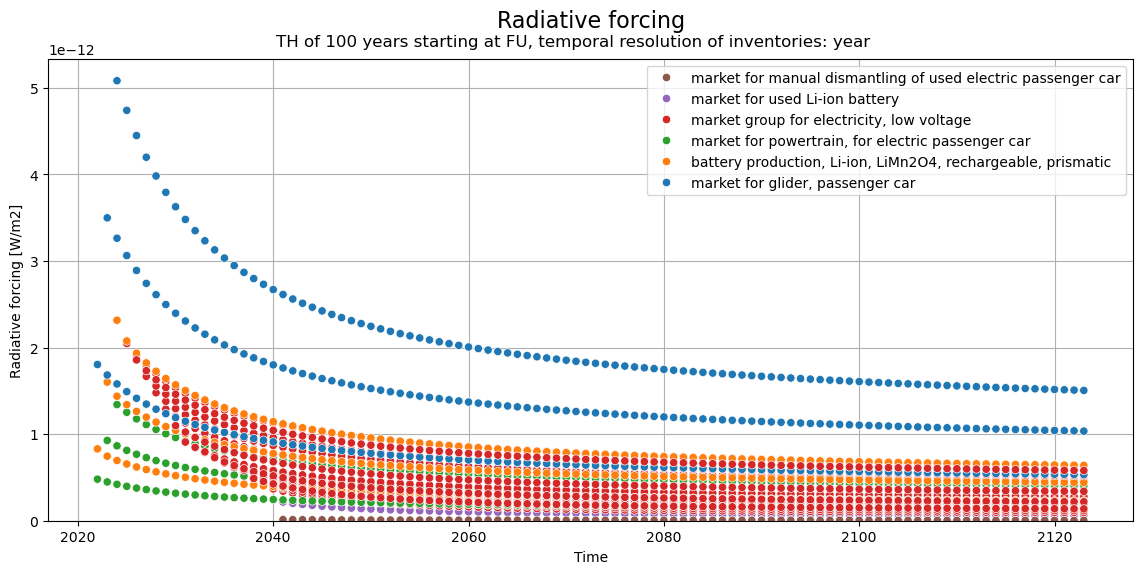

In [25]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

Without summing up the emissions within the activity, one can see that there are also negative emissions in the system, which stem from the premise-induced BECCS in the future electricity production:

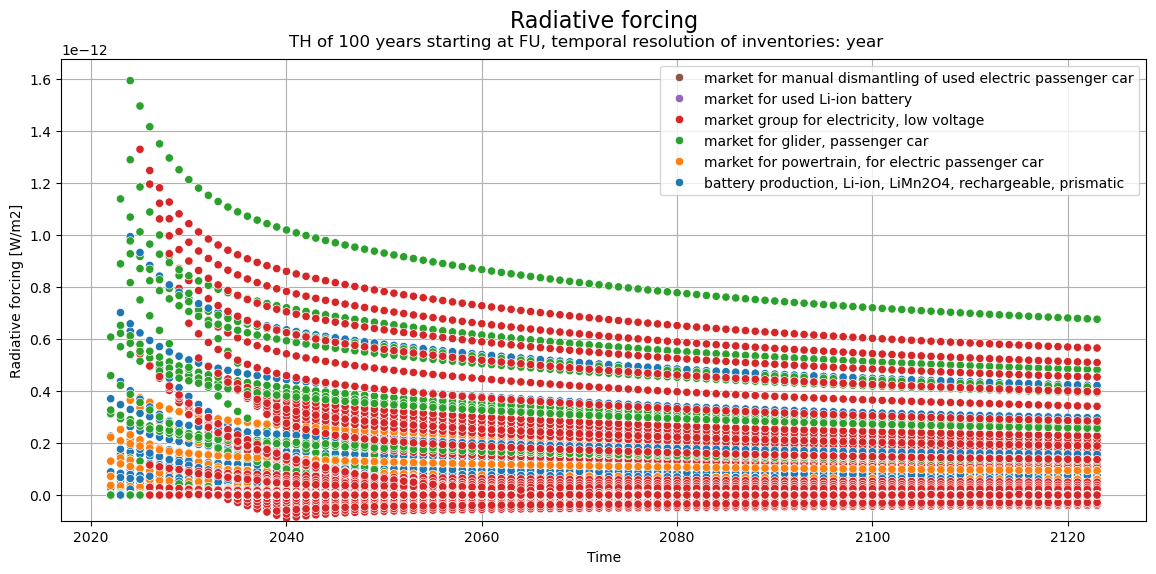

In [26]:
tlca.plot_dynamic_characterized_inventory()  

Cumulative radiative forcing:

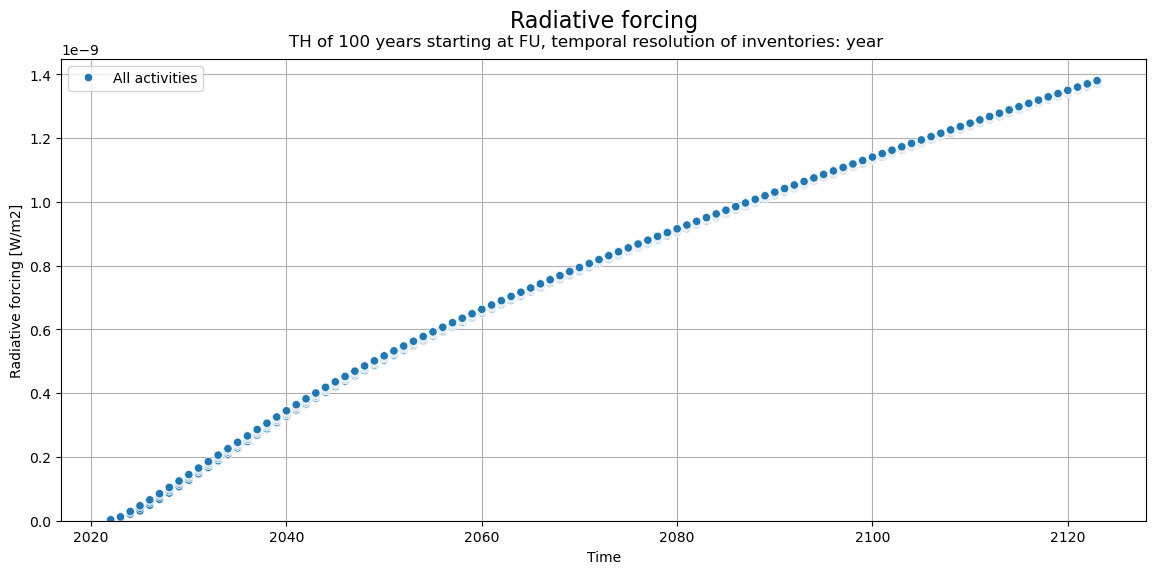

In [27]:
tlca.plot_dynamic_characterized_inventory(sum_activities= True, cumsum=True)

### GWP


Similar options are available for the metric GWP, which compares the radiative forcing of a GHG to that of CO2 over a certain time horizon (commonly 100 years, but it can be set flexibly in `time_horizon`).

In [28]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=False, time_horizon = 70)
tlca.dynamic_score #kg CO2-eq (GWP)

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:44: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions based on IPCC AR6 meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)'). You can look up the mapping in the timex_lca.dynamic_characterizer.characterization_function_dict.
  warnings.warn(
c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:89: UserWarning: Using timex_lca's default co2 characterization function for GWP reference.
  warnings.warn(


16226.567634709636

Plotting the GWP results over time:

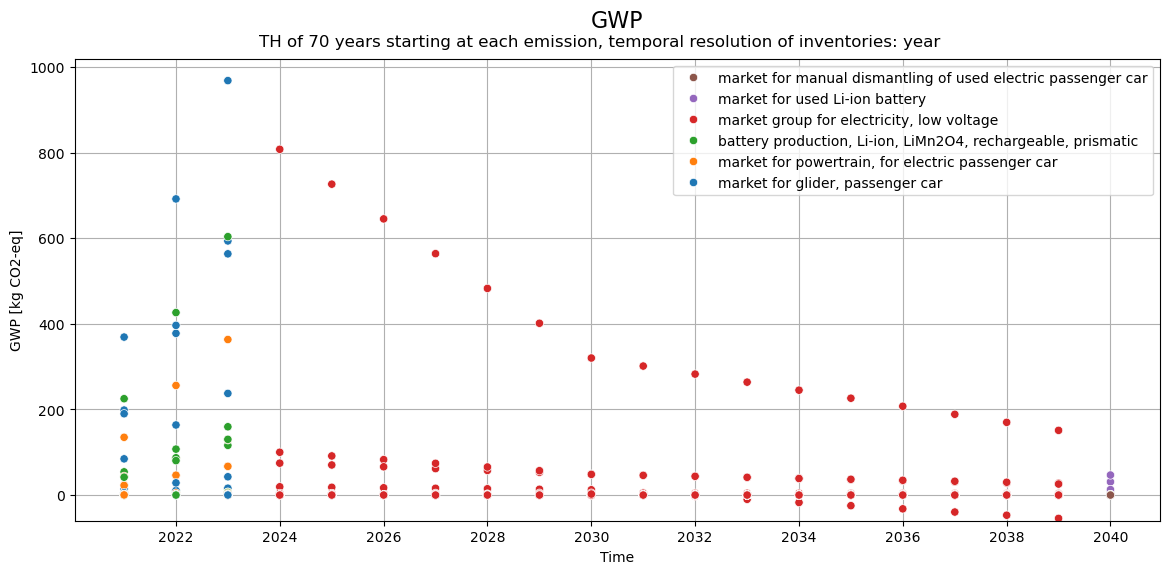

In [29]:
tlca.plot_dynamic_characterized_inventory()

Cumulative:

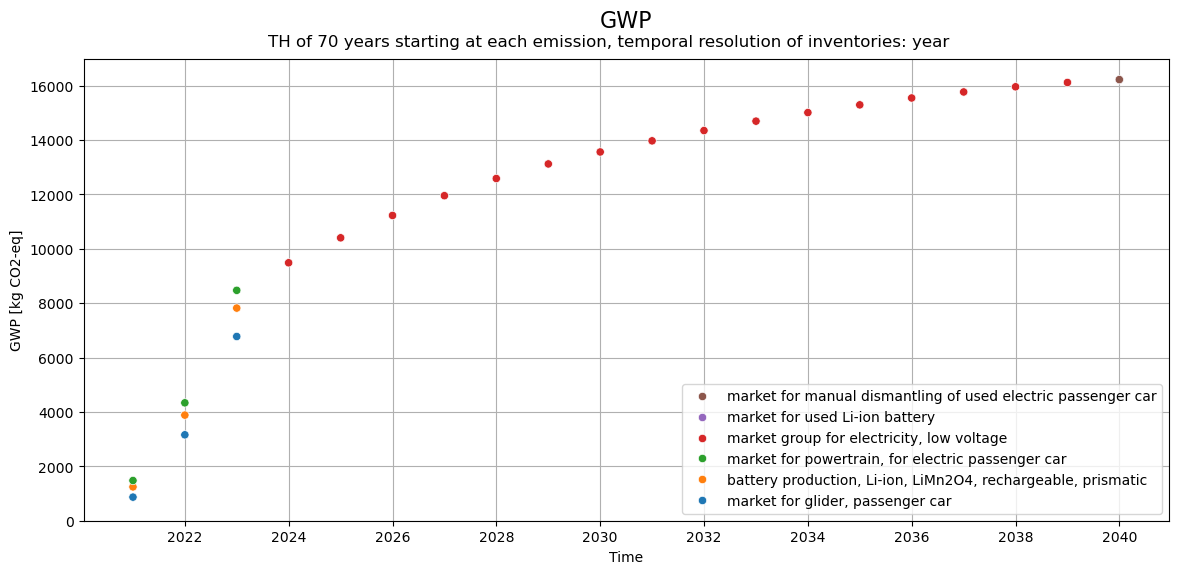

In [30]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=True)

### Comparison of time-explicit results to static results
It's helpful to understand how the time-explicit results differ from those using static assessments. 

We compare the time-explicit results with those of an LCA for the year 2020 and 2040 for the standard GWP100 metric (time horizon=100 and no fixed time horizon). This means we neglect the additional differences of the time-explicit results that would arise from using dynamic LCIA. 

Time-explicit scores:

In [31]:
tlca.dynamic_lcia(metric="GWP", fixed_time_horizon=False, time_horizon=100)
tlca.dynamic_score

c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:44: UserWarning: No custom dynamic characterization functions provided. Using default dynamic characterization functions based on IPCC AR6 meant to work with biosphere3 flows. The flows that are characterized are based on the selection of the initially chosen impact category: ('EF v3.1', 'climate change', 'global warming potential (GWP100)'). You can look up the mapping in the timex_lca.dynamic_characterizer.characterization_function_dict.
  warnings.warn(
c:\users\mullera\onedrive - vito\documents\04_coding\tictac_lca\timex_lca\dynamic_characterization.py:89: UserWarning: Using timex_lca's default co2 characterization function for GWP reference.
  warnings.warn(


15769.830221056744

Calculation of 2020 scores:

In [32]:
import bw2calc as bc

static_scores = {}
for e in ev_lifecycle.exchanges():
    if e.input == ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    static_scores[e.input["name"]] = lca.score

Calculation of 2040 scores:

In [33]:
#first create a copy of the system and relink to processes from 2040 database
prospective_ev_lifecycle = ev_lifecycle.copy()

for exc in prospective_ev_lifecycle.exchanges():
    if exc.input == prospective_ev_lifecycle:
        continue
    exc.input = bd.get_node(
        **{
            "database": "db_2040",
            "name": exc.input["name"],
            "product": exc.input["reference product"],
            "location": exc.input["location"],
        }
    )
    exc.save()

prospective_scores = {}
for e in prospective_ev_lifecycle.exchanges():
    if e.input == prospective_ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    prospective_scores[e.input["name"]] = lca.score

Plotting scores next to each other, with the time-explicit score as a waterfall bar based on timing of emission.

time-explicit score: 15769.83
static score: 31401.50
prospective score: 7234.10


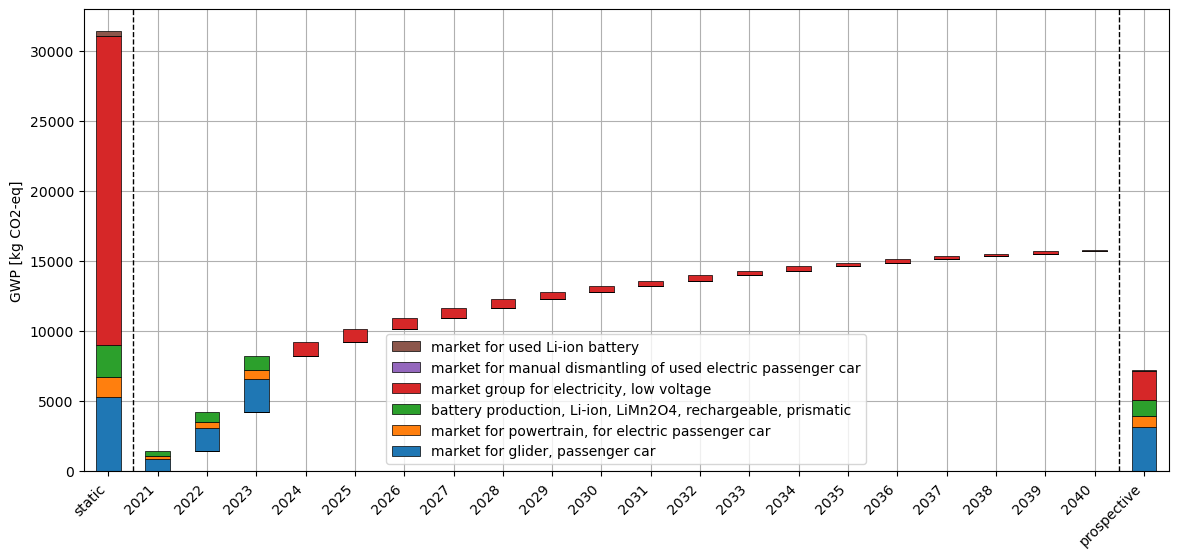

In [34]:
from timex_lca.utils import plot_characterized_inventory_as_waterfall

order_stacked_activities = (
    [  # to sort stacked bars in waterfall plot chronologically from production to EoL
        "market for glider, passenger car",
        "market for powertrain, for electric passenger car",
        "battery production, Li-ion, LiMn2O4, rechargeable, prismatic",
        "market group for electricity, low voltage",
        "market for manual dismantling of used electric passenger car",
        "market for used Li-ion battery",
    ]
)

plot_characterized_inventory_as_waterfall(
    tlca.characterized_inventory,
    metric=tlca.metric,
    static_scores=static_scores,
    prospective_scores=prospective_scores,
    order_stacked_activities=order_stacked_activities,
)

One can see that the time-explicit results (in the middle) are somewhere in between the static and the prospective results. This makes sense as at each timestep, the underlying processes are sourced from progressively "cleaner" background databases, reaching a lower impact than if they are only sourced from the current database, but not so low as the prospective results, which are fully sourced from the most decarbonized database. Notably, the electricity consumption in the use-phase, modelled uniformly over the lifetime of the EV, contributes less and less to the score in the later years, since the electricity becomes cleaner in the future databases.